# Trainers

In this notebook I test trainer implementations on various environments.

## Monitoring setup
This sets up the logging system to be able to monitor the training progress of the agent

In [2]:
import logging
from amarl.messenger import training_monitor

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s:%(name)s: %(message)s')
logging.root.setLevel(logging.INFO)

logger = logging.getLogger(__name__)

## Train the Agent
In the part I actually train the agent on one of the testing environments. It is a good idea to look at the gym unit
testing environment first and try to solve that. If this doesn't work, there is something wrong either with the
algorithm or the setup. Also make sure to sanity check input signal. Here the problem was that the input image was
actually completely mangled by the torch vision pipeline because I used it wrong initally.

In [5]:
import amarl
import gym
from amarl.trainers import A2CTrainer
from amarl.wrappers import MultipleEnvs, active_gym, OriginalReturnWrapper, SignReward,  TorchObservation, StackFrames

def make_env():
    e = gym.make('CubeCrash-v0')
    e = OriginalReturnWrapper(e)
    e = SignReward(e)
    e = TorchObservation(e)
    e = StackFrames(e, size=4)
    return e

env = MultipleEnvs(make_env, num_envs=16)
with active_gym(env) as env, training_monitor(logger, performance_sample_size=10000) as monitor:
    com = A2CTrainer(env, config={'rollout_horizon': 5, 'device': 'cuda'})
    try:
        amarl.run(com, num_steps=int(1e5))
    finally:
        pass

/home/bernhard/miniconda3/envs/AMARL/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

2020-04-11 16:11:30,743 - INFO:__main__: steps:    3296, average reward:	-0.19
2020-04-11 16:11:32,222 - INFO:__main__: steps:    6719, average reward:	+0.33
2020-04-11 16:11:33,645 - INFO:__main__: steps:   10000, performance:	2276.51 steps/s
2020-04-11 16:11:33,684 - INFO:__main__: steps:   10080, average reward:	+0.53
2020-04-11 16:11:35,140 - INFO:__main__: steps:   13472, average reward:	+0.76
2020-04-11 16:11:36,717 - INFO:__main__: steps:   16990, average reward:	+0.74
2020-04-11 16:11:38,002 - INFO:__main__: steps:   20000, performance:	2295.28 steps/s
2020-04-11 16:11:38,205 - INFO:__main__: steps:   20464, average reward:	+0.98
2020-04-11 16:11:39,674 - INFO:__main__: steps:   23856, average reward:	+1.05
2020-04-11 16:11:41,205 - INFO:__main__: steps:   27408, average reward:	+1.02
2020-04-11 16:11:42,315 - INFO:__main__: steps:   30000, performance:	2319.48 steps/s
2020-04-11 16:11:42,708 - INFO:__main__: steps:   30912, average reward:	+0.94
2020-04-11 16:11:44,183 - INFO:

## Plot Results
It is easier to understand how the agent is performing by plotting the metrics of the training. Sum bugs can be subtle,
for instance it was not that obvious that the frame stack ordering was wrong, because the agent still learned a good
policy and performed reasonably well. Because of such subtle bugs the algorithm can become more sensitive to certain
hyper-parameters (i.e. gradient clipping), resulting in a misleading perception of importance of these parameters. Be
careful!

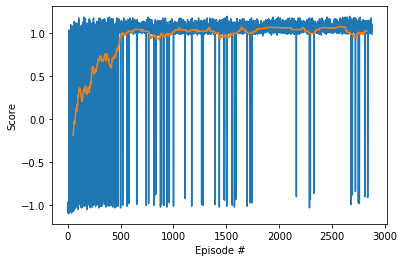

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(a, n=3):
    ret = np.cumsum(np.insert(a, 0, 0))
    return (ret[n:] - ret[:-n]) / n

scores = monitor.captured_returns
avg_window = 100
scores_avg = moving_average(scores, avg_window)
fig, ax = plt.subplots()
ax.plot(range(len(scores)), scores)
start = avg_window // 2
ax.plot(range(start, start + len(scores_avg)), scores_avg)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
